首先，引用所需的库

In [24]:
import matplotlib
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import argparse
from scipy import signal
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from operator import itemgetter
from pretty_confusion_matrix import pp_matrix_from_data

以下为主要函数的附属函数：

In [25]:
def isvalidactid(mode):  #下一个函数里调用的一个小函数，判断mode数组（标签）的正确性，如果数组全为整数并且在1-6之间则返回ture
    if isinstance(mode, int):
        isit = np.trunc(mode) == mode and 0 < mode <= 6
    else:
        isit = all(np.trunc(mode) == mode) and all(0 < i <= 6 for i in mode)

    return isit


In [26]:
def addActivityLegend(mode):#给活动增加标签，对应MATLAB程序中的addActivityLegend
    if mode is []:
        return
    data = io.loadmat(
        'D:\!\课业\大三下\signal processing\实验课\第一次实验课\SignalProcessingForMachineLearning\Data\Prepared\RecordedAccelerationsBySubject.mat')
    actlabels = data['actnames']

    if isinstance(mode, str) and mode == 'all':
        plt.legend(actlabels)
    elif isvalidactid(mode):
        if isinstance(mode, int):
            leg = [actlabels[0][mode-1][0]]
        else:
            leg = [actlabels[0][s-1][0] for s in mode]  # 遍历mode创建图例列表
        plt.legend(leg)


In [27]:
def plotHistogram(acc, id, actstr):#绘制直方图函数，对应MATLAB程序中的plotCompareHisForActivities函数中的
#plotHistogram函数
    data = io.loadmat(
        'D:\!\课业\大三下\signal processing\实验课\第一次实验课\SignalProcessingForMachineLearning\Data\Prepared\RecordedAccelerationsBySubject.mat')
    actlabels = data['actnames']
    actid = np.where((actlabels == np.array(actstr)))[1] + 1  # 查找此动作类型的编号
    sel = np.where(id[:, 0] == actid)  # 查找此动作类型所对应的数据索引
    asel = acc[:, sel]
    nacts = actlabels.shape[1]

    colors = matplotlib.colors.BASE_COLORS
    c = list(colors.values())[int(actid-1)]
    plt.hist(asel[0, 0], color=c)  # 绘制直方图

    plt.xlabel('Acceleration Values (m/s$^{2}$)')
    plt.ylabel('Occurencies')
    plt.xlim([np.min(acc), np.max(acc)])

    addActivityLegend(actid)


In [28]:
def getDataForActivityId(ka, kp, acc, acts, actid, t):
    #对应MATLAB中plotAccelerationColouredByActivity函数中的getDataForActivityId
    #获取活动类型对应的加速度及其对应x轴时间数据
    try:
        aid = acts[ka]
    except:
        aid = 1
    finally:
        pass
    sel = np.where(actid == aid)[0]  # 查找此动作类型所对应的数据索引
    if sel.size > 0:
        tsel = np.full(t.size, np.nan)  # 创建空数组
        tsel[sel] = t[:, sel]  # 用此索引给时间x轴赋值，加速度同理
        aselt = acc[kp]
        asel = np.full(aselt.size, np.nan)
        asel[sel] = aselt[:, sel]
        return aid, tsel, asel
    else:
        return aid, t[0, :], acc[0, :]


In [29]:
def bwlabels1(x):
    #对应MATLAB中bwlabels1函数

    dif = np.diff(x)
    loc = np.where(dif > 1)
    labs = x[0:int(loc[0][0]) + 1]
    return labs


In [30]:
def covFeatures(x, fs):
    #对应MATLAB中featureFromBuffer函数中的covFeatures函数
    #获取自相关类的特征
    feats = np.zeros(3)
    lags, c, _, _ = plt.acorr(x, maxlags=None)#做自相关
    #c是自相关结果，lag是滞后
    plt.close()

    minprom = 0.0005
    mindist_xunits = 0.3
    minpkdist = np.trunc(mindist_xunits/(1/fs))
    #寻找自相关后的峰值
    locs, properties = signal.find_peaks(c, distance=minpkdist, prominence=minprom)
    pks = c[locs]

    tc = 1/fs*lags
    tcl = tc[0, locs]
    if(len(tcl) > 0):
        feats[0] = pks[int((len(pks)+1)/2)]
    if(len(tcl) >= 3):
        feats[1] = tcl[int((len(pks)+1)/2)+1]
        feats[2] = pks[int((len(pks)+1)/2)+1]

    return feats

In [31]:
def spectralPeaksFeatures(x, fs):
    #对应MATLAB中featureFromBuffer函数中的spectralPeakFeatures函数
    #获取功率谱峰值中的特征
    mindist_xunits = 0.3

    feats = np.zeros(12)

    N = 4096
    minpkdist = np.trunc(mindist_xunits/(fs/N))

    window = signal.get_window('boxcar', len(x))
    f, p = signal.welch(x, fs, window, nfft=N)

    locs,_ = signal.find_peaks(p, distance=minpkdist)
    pks = p[locs[0:20 if len(locs)>20 else len(locs)]]

    if(len(pks) > 0):
        mx = np.min([6, len(pks)])
        spks = sorted(pks, reverse=True)
        idx = np.argsort(-pks)
        slocs = locs[idx]

        pks = np.array(spks[0:mx])
        locs = slocs[0:mx]

        slocs = sorted(locs)
        idx = np.argsort(locs)
        spks = pks[idx]
        pks = spks
        locs = np.array(slocs)

    fpk = f[0,locs]

    feats[0:len(pks)] = fpk
    feats[6:6+len(pks)] = pks

    return feats


In [32]:
def spectralPowerFeatures(x, fs):
    #对应MATLAB中featureFromBuffer函数中的spectralPowerFeatures函数
    #获取PSD中的特征
    feats = np.zeros(5)

    edges = [0.5, 1.5, 5, 10, 15, 20]

    [f, p] = signal.periodogram(x, fs, nfft=4096)

    for kband in range(len(edges) - 1):
        feats[kband] = sum(p[np.intersect1d(np.where(f >= edges[kband])[
                           1], np.where(f < edges[kband+1])[1])])

    return feats


In [33]:
def rms(records):
    #python中没有自带的rms，计算均方根
    return np.sqrt(sum([x ** 2 for x in records]) / len(records))

以下为实现具体功能的主要函数：

In [34]:
def getRawAcceleration(**kwargs):
    data = io.loadmat(
        'D:\!\课业\大三下\signal processing\实验课\第一次实验课\SignalProcessingForMachineLearning\Data\Prepared\RecordedAccelerationsBySubject.mat')
    subjects = data['subjects']
    fs = data['fs']
    actnames = data['actnames']
    p = argparse.ArgumentParser(description='Get Raw Acceleration')
    defaultAccelerationType = 'total'  # 默认的加速度数据类型
    validAccelerationTypes = ['total', 'body']  # 可选的加速度数据类型

    defaultSubject = 1  # 默认的受试人员编号

    defaultComponent = 'x'  # 默认的加速度轴
    validComponents = ['x', 'y', 'z']  # 可选的加速度轴

    # 下列语句用于给p添加所需参数与限定其范围
    p.add_argument('-sid', '--SubjectID', default=defaultSubject,
                   type=int, choices=range(1, 31))
    p.add_argument('-acc', '--AccelerationType',
                   default=defaultAccelerationType, choices=validAccelerationTypes)
    p.add_argument('-com', '--Components', default=defaultComponent,
                   choices=validComponents)

    # sid = str(kwargs['SubjectID']) if 'SubjectID' in kwargs else defaultSubject
    # a = kwargs['AccelerationType'] if 'AccelerationType' in kwargs else defaultAccelerationType
    # c = kwargs['Components'] if 'Components' in kwargs else defaultComponent
    # 为参数赋值
    a = list(kwargs.items())
    for i in range(len(a)):
        a[i] = list(a[i])
        a[i][0] = '--'+a[i][0]
    a = sum(a, [])
    args = p.parse_args(a)
    # args = p.parse_args(['1','total','x'])

    # 使用字典对应关系提取参数
    acctype = {'total': 1, 'body': 2}
    componenttype = {'x': 0, 'y': 1, 'z': 2}
    subid = args.SubjectID

    type = acctype[args.AccelerationType]
    component = componenttype[args.Components]

    # 提取数据
    # subjects是一个长度30的array,内层每个元素都是一个长度为2的array
    # array内层为一个22722*1的actid与一个22722*3的加速度三轴数据。
    # 如果total与body数据都有的话就是两组加速度三轴数据
    acc = subjects[0][subid-1][type][:, component]
    actid = subjects[0][subid-1][0]
    t = (1 / fs) * range(0, len(acc))
    return np.matrix(acc), actid, actnames, t, fs


In [35]:
def plotAccelerationColouredByActivity(t, acc, actid, *args):
    acts = np.unique(actid)  # 去重
    nacts = np.max([len(acts), 1])
    nplots = acc.shape[0]
    # colors = mpl.colors.BASE_COLORS

    for kp in range(nplots):
        plt.figure()
        plt.subplot(nplots, 1, kp + 1)
        for ka in range(nacts):
            [aid, tsel, asel] = getDataForActivityId(
                ka, kp, acc, acts, actid, t)  # 获取这一加速度类型的数据
            plt.plot(tsel, asel)
        plt.grid()
        plt.xlabel('time (s)')
        plt.ylabel('a$_{z}$ (m/s$^{-2}$)')
        plt.xlim([t[0, 0], t[0, -1]])
        plt.title(args[kp])

    addActivityLegend(acts)  # 制作图例

    plt.show()


In [36]:
def plotCompareHistForActivities(acc, actid, actname1, actname2):

    plt.figure()

    plt.subplot(211)
    plotHistogram(acc, actid, actname1)

    plt.subplot(212)
    plotHistogram(acc, actid, actname2)

    plt.tight_layout()
    plt.show()


In [37]:
def hpfilter():#高通滤波器
    fs = 50
    wp = 0.8
    ws = 0.4
    gstop = 60
    gpass = 1
    b, a = signal.iirdesign(wp, ws, gpass, gstop, ftype='cheby2', fs=fs)
    return b, a


In [38]:
def plotPSDActivityComparisonForSubject(subject, act1name, act2name):
    [acc, actid, _, _, fs] = getRawAcceleration(SubjectID=subject)

    b, a = hpfilter()
    ab = signal.filtfilt(b, a, acc)
    s = io.loadmat(
        'D:\!\课业\大三下\signal processing\实验课\第一次实验课\SignalProcessingForMachineLearning\Data\Prepared\BufferedAccelerations.mat')
    actlabels = s['actnames']
    id = np.zeros(2)
    id[0] = np.where((actlabels == np.array(act1name)))[1] + 1
    id[1] = np.where((actlabels == np.array(act2name)))[1] + 1

    for k in range(len(id)):
        sel = np.where(id[k] == actid)[0]
        reglabs = bwlabels1(sel)
        d = ab[:, reglabs]
        f, pxx = signal.welch(d, fs, window='hamming')
        plt.plot(f[0], 20*np.log10(pxx[0]))

    plt.grid()
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/frequency (dB/Hz)')
    plt.xlim([0, 10])
    plt.title('Power Spectral Density Comparison')

    addActivityLegend(np.int64(id))  # 制作图例

    plt.show()


In [39]:
def plotPSDForGivenActivity(activityid):
    b, a = hpfilter()
    ax = plt.axes(projection='3d')
    colors = matplotlib.colors.BASE_COLORS
    c = list(colors.values())[activityid-1]
    for subject in range(30):
        [acc, actid, _, _, fs] = getRawAcceleration(SubjectID=str(subject+1))
        ab = signal.filtfilt(b, a, acc)
        sel = np.where(actid == activityid)[0]
        reglabs = bwlabels1(sel)
        d = ab[:, reglabs]
        f, pxx = signal.welch(d, fs, window='hamming')
        ax.plot3D(np.ones(f.size) * (subject + 1),
                  f[0], 20*np.log10(pxx[0]), color=c)

    plt.grid()
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Subject ID')
    addActivityLegend(activityid)  # 制作图例

    plt.show()


In [40]:
def plotCorrActivityComparisonForSubject(subject, act1name, act2name):
    [acc, actid, _, _, fs] = getRawAcceleration(SubjectID=subject)

    b, a = hpfilter()
    ab = signal.filtfilt(b, a, acc)
    s = io.loadmat(
        'D:\!\课业\大三下\signal processing\实验课\第一次实验课\SignalProcessingForMachineLearning\Data\Prepared\BufferedAccelerations.mat')
    actlabels = s['actnames']
    id = np.zeros(2)
    id[0] = np.where((actlabels == np.array(act1name)))[1] + 1
    id[1] = np.where((actlabels == np.array(act2name)))[1] + 1
    data = {'lags':[],'c':[]}

    for k in range(len(id)):
        sel = np.where(id[k] == actid)[0]
        reglabs = bwlabels1(sel)
        d = ab[:, reglabs][0]
        lags, c, _, _ = plt.acorr(d, maxlags=None)
        data['lags'].append(lags)
        data['c'].append(c)
    
    plt.clf()
    for k in range(len(id)):
        tc = (1/fs[0])*data['lags'][k]
        plt.plot(tc,data['c'][k],'.-')

    plt.grid()
    plt.xlim([-5,5])
    
    plt.title('Autocorrrelation Comparison')
    plt.xlabel('Time lag (s)')
    plt.ylabel('Correlation')

    addActivityLegend(np.int64(id))
    plt.show()
    

In [41]:
def featuresFromBuffer(atx, aty, atz, fs):
    b, a = hpfilter()
    feat = np.zeros(66)

    abx = signal.lfilter(b, a, atx)
    aby = signal.lfilter(b, a, aty)
    abz = signal.lfilter(b, a, atz)

    feat[0] = np.mean(atx)
    feat[1] = np.mean(aty)
    feat[2] = np.mean(atz)

    feat[3] = rms(abx)
    feat[4] = rms(aby)
    feat[5] = rms(abz)

    feat[6:9] = covFeatures(abx, fs)
    feat[9:12] = covFeatures(aby, fs)
    feat[12:15] = covFeatures(abz, fs)

    feat[15:27] = spectralPeaksFeatures(abx, fs)
    feat[27:39] = spectralPeaksFeatures(aby, fs)
    feat[39:51] = spectralPeaksFeatures(abz, fs)

    feat[51:56] = spectralPowerFeatures(abx, fs)
    feat[56:61] = spectralPowerFeatures(aby, fs)
    feat[61:66] = spectralPowerFeatures(abz, fs)

    return feat


In [42]:
def plotAccelerationBufferAndPrediction(x, y, z, t, actual, estimated):
    g = 9.81
    plt.figure()
    plt.xlim([0, t[0][t.size-1]])
    plt.ylim([-2*g, 2*g])
    plt.xlabel('Time offset (s)')
    plt.ylabel('Acceleration (m/s$^{2}$)')
    plt.grid()
    plt.title('Estimated:{}\nActually:{}\n'.format(estimated, actual))
    plt.plot(t[0], g*np.array([x, y, z]).T)
    plt.legend(['a_x', 'a_y', 'a_z'])
    plt.pause(1)
    # jupyter notebook所需（我也不懂）
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [62]:
# 定义自己的神经网络类
class my_net(nn.Module):#神经网络的类，包括定义层和前向传播
    def __init__(self):#定义层
        super(my_net, self).__init__()
        self.hidden1 = nn.Linear(in_features=66, out_features=30)
        self.hidden2 = nn.Linear(in_features=30, out_features=18)
        self.output = nn.Linear(in_features=18, out_features=6)
        self.relu = nn.ReLU()#激活函数

    def forward(self, x):#前向传播
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.hidden2(x)
        x = self.relu(x)
        x = self.output(x)
        return x

# Trainset、Testset：创建Dataset类数据集（神经网络需要）
# 数据集类必须包括数据本身、检测数据长度方法（__len__）与提取数据方法（__getitem__）
class Trainset(Dataset):#定义神经网络需要的数据集
    def __init__(self):#数据集里的数据
        self.data = torch.tensor(X_train,dtype=torch.float)
        self.labels = torch.tensor(y_train,dtype=torch.float)

    def __len__(self):#数据集长度
        return len(self.data)

    def __getitem__(self, idx):#提取数据集数据的方式
        return self.data[idx], self.labels[idx]


class Testset(Dataset):#测试集
    def __init__(self):
        self.data = torch.tensor(X_test,dtype=torch.float)
        self.labels = torch.tensor(y_test,dtype=torch.float)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# 创建神经网络数据迭代器
def data_loader(mini_batch_size):#mini_batch_size每一批次使用数据的规格
    train_set = Trainset()
    test_set = Testset()
    train_data = DataLoader(train_set, mini_batch_size, shuffle=True)#迭代器
    test_data = DataLoader(test_set, mini_batch_size, shuffle=True)

    return train_data, test_data

# 测试网络
def test_net(net, test_data):
    test_acc = 0
    total_1 = 0
    for step, (im, labels) in enumerate(test_data):
        im = Variable(im)
        labels = Variable(labels)
        net.eval() # 将网络调整至预测状态
        out = net(im)
        _, pred = out.max(1) # 输出为预测类型（0-5）
        total_1 += labels.size(0)
        test_acc += (pred == labels).sum()

    return 100. * test_acc.cpu().numpy() / total_1

# 训练网络
def train(epochs, mini_banch_size, eta):
    train_data, test_data = data_loader(mini_banch_size)
    
    net = my_net().to(device)#网络初始化
    
    criterion = nn.CrossEntropyLoss() # 交叉熵损失函数

    optimizer = torch.optim.Adam(net.parameters(), eta) # Adam：训练迭代方法
    losses = []
    test_acces = []
    best_acc = 0

    for e in range(epochs):
        train_loss = 0
        for step, (data, label) in enumerate(train_data):
            label = label.to(torch.int64)
            net.train() # 将网络调整至训练状态
            data = Variable(data) # 将其转为变量，以便反向传播
            label = Variable(label)
            out = net(data) # 网络输出
            loss = criterion(out, label) # 计算交叉熵
            optimizer.zero_grad() # 将每个batch的梯度初始化为0
            loss.backward() # 反向传播
            optimizer.step() # 更新网络中参数
            train_loss += loss.item()

        losses.append(train_loss / (step + 1))
        accuracy_test = test_net(net, test_data)
        test_acces.append(accuracy_test)
        print('epoch %d | loss = %.4f,test accuracy is %.3f%%.' % (e, train_loss / (step + 1), accuracy_test))
        if accuracy_test > best_acc:
            best_net = net
            best_acc = accuracy_test
            torch.save(net, 'C:/Users/bailing/Desktop/siganl processing/model/est_model.pth') # 保存模型
    print('best acc = %.3f' % best_acc)
    return losses, test_acces, best_net


以下引用主要函数实现功能。

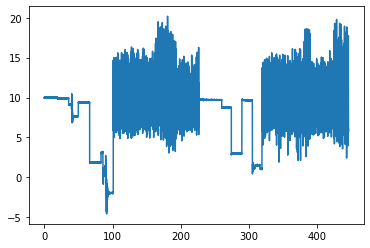

In [45]:
# Open full "recording" for a single subject (e.g. #1)
[acc, actid, actlabels, t, fs] = getRawAcceleration(SubjectID='1', AccelerationType='total',
                                                    Components='x')

plt.plot(t[0, :], np.array(acc)[0, :])
plt.show()


成功提取出了数据并绘制出了图像。

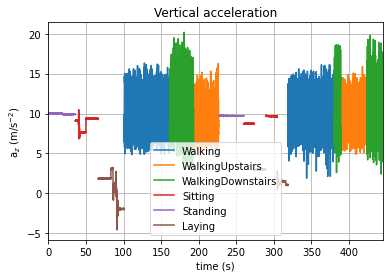

In [46]:
# A more detailed look into the data
plotAccelerationColouredByActivity(t, acc, actid, 'Vertical acceleration')


将加速度按运动标签区分并以不同颜色绘制在同一张图上。

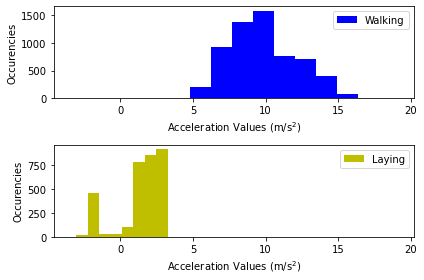

In [47]:
# First example - Using a mean measure
plotCompareHistForActivities(acc, actid, 'Walking', 'Laying')

比较直方图，从数据的均值可以很容易地区分走与躺两种运动方式。

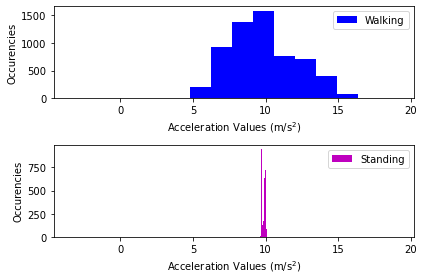

In [48]:
# Second example - Using an RMS or standard deviation measure
plotCompareHistForActivities(acc, actid, 'Walking', 'Standing')


比较直方图，从数据的均方差可以很容易地区分走与站立两种运动方式。

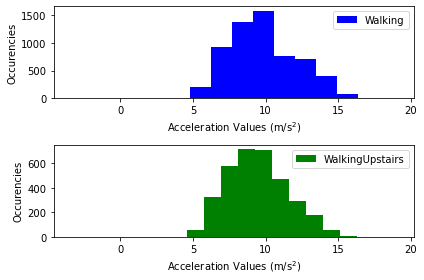

In [49]:
# What next? Amplitude-only methods are often not enough
plotCompareHistForActivities(acc, actid, 'Walking', 'WalkingUpstairs')


比较直方图，发现已经没有足够直观的数据特征来区分走与上楼两种动作类型。

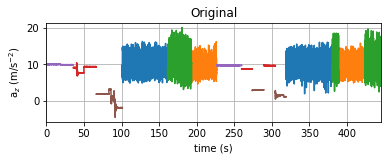

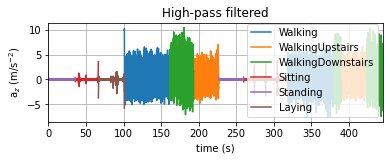

In [50]:
# Time-domain analysis - preliminary considerations
b, a = hpfilter()
ab = signal.filtfilt(b, a, acc)
plotAccelerationColouredByActivity(t, np.vstack(
    (acc, ab)), actid, 'Original', 'High-pass filtered')


将数据进行高通滤波，并按动作类型标签绘制。

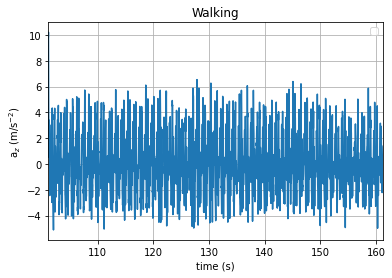

In [51]:
# Focus on a single activity first: select first portion of Walking signal
walking = 1
sel = np.intersect1d(np.where(t < 250)[1], np.where(actid == walking)[0])
tw = t[:,sel]
abw = ab[:,sel]
plotAccelerationColouredByActivity(tw,abw,[],'Walking')

选择第250秒前，运动类型为步行的样本，绘制其图像

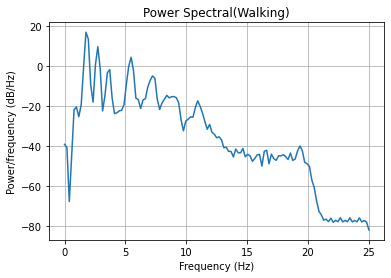

In [52]:
# Plot Power Spetral Density
f, pxx = signal.welch(abw, fs, window='hamming')
plt.plot(f[0], 20*np.log10(pxx[0]))

plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/frequency (dB/Hz)')
plt.title('Power Spectral(Walking)')

plt.show()

绘制所选样本的功率谱密度

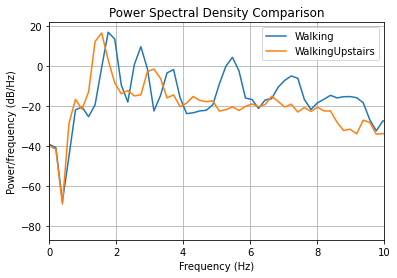

In [53]:
plotPSDActivityComparisonForSubject('1', 'Walking', 'WalkingUpstairs')

比较走路与上楼两种加速度的功率谱密度

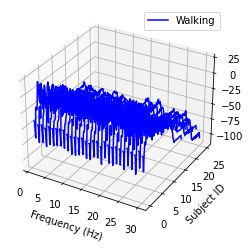

In [54]:
# Validate consistency of PSD information across different subjects
plotPSDForGivenActivity(walking)

比较不同受试人员走路加速度的功率谱密度

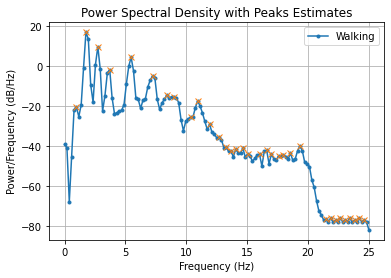

In [55]:
# Automate peak identification
f, pxx = signal.welch(abw,fs,window='hamming')
pxx_plot = 20*np.log10(pxx[0])
pks, locs = signal.find_peaks(pxx_plot)
plt.plot(f[0], pxx_plot,'.-')
plt.plot(f[0][pks], pxx_plot[pks], 'x')
plt.grid()
plt.title('Power Spectral Density with Peaks Estimates')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
addActivityLegend(1)
plt.show()

寻找功率谱密度的峰值（不加限制条件）

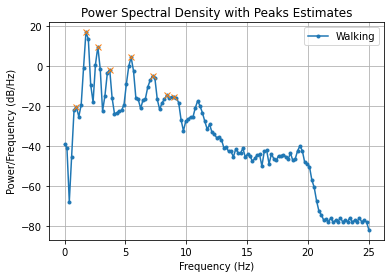

In [56]:
# Refine peak finding by adding more specific requirements
f, pxx = signal.welch(abw,fs,window='hamming')

fmindist = 0.25
N = 2*(f.size-1)
minpkdist = np.trunc(fmindist/(fs/N))

pxx_plot = 20*np.log10(pxx[0])
pks, locs = signal.find_peaks(pxx_plot, distance=minpkdist, prominence=0.15)
plt.plot(f[0], pxx_plot,'.-')
plt.plot(f[0][pks[0:8]], pxx_plot[pks[0:8]], 'x')
plt.grid()
plt.title('Power Spectral Density with Peaks Estimates')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
addActivityLegend(1)
plt.show()

寻找功率谱密度的峰值（频率最小距离为0.25Hz的前八个峰值点）

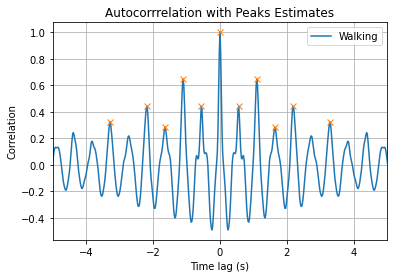

In [57]:
# Autocorrelation as a feature
lags, c, _, _ = plt.acorr(abw[0], maxlags=None)
plt.clf()

tmindist = 0.3
minpkdist = np.trunc(tmindist*fs)

pks, locs = signal.find_peaks(c, distance=minpkdist, prominence=0.5)
tc = (1/fs[0])*lags
plt.plot(tc, c)
plt.plot(tc[pks], c[pks], 'x')
plt.grid()
plt.xlim([-5, 5])
addActivityLegend(1)
plt.title('Autocorrrelation with Peaks Estimates')
plt.xlabel('Time lag (s)')
plt.ylabel('Correlation')
plt.show()


寻找功率谱密度自相关的峰值

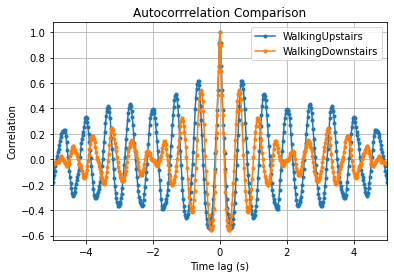

In [58]:
plotCorrActivityComparisonForSubject('1', 'WalkingUpstairs', 'WalkingDownstairs')

比较上楼与下楼加速度功率谱密度的自相关

In [61]:
feat = io.loadmat(
    'D:\!\课业\大三下\signal processing\实验课\第一次实验课\SignalProcessingForMachineLearning\Data\Prepared\BufferFeatures.mat')['feat']
actdata = io.loadmat(
    'D:\!\课业\大三下\signal processing\实验课\第一次实验课\SignalProcessingForMachineLearning\Data\Prepared\BufferedAccelerations.mat')
actid, atx, aty, atz, actnames, fs, t = itemgetter(
    *['actid', 'atx', 'aty', 'atz', 'actnames', 'fs', 't'])(actdata)
actid = actid[:,0] - 1
# 提取数据，并将标签-1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 选择神经网络使用GPU还是CPU
X_train, X_test, y_train, y_test = train_test_split(feat, actid)
# 划分训练数据与测试数据

cpu


提取神经网络所需特征数据，划分训练集与测试集

In [63]:
epochs = 300 # 训练轮次
mini_batch_size = 64 # 一个batch大小

eta = 0.01 # 学习率
train_loss, test_accuracy, best_net = train(epochs, mini_batch_size, eta) # 训练

epoch 0 | loss = 0.6466,test accuracy is 84.621%.
epoch 1 | loss = 0.3436,test accuracy is 86.835%.
epoch 2 | loss = 0.3223,test accuracy is 88.777%.
epoch 3 | loss = 0.3056,test accuracy is 88.233%.
epoch 4 | loss = 0.2725,test accuracy is 88.893%.
epoch 5 | loss = 0.2607,test accuracy is 88.311%.
epoch 6 | loss = 0.2668,test accuracy is 86.835%.
epoch 7 | loss = 0.2530,test accuracy is 90.097%.
epoch 8 | loss = 0.2637,test accuracy is 88.505%.
epoch 9 | loss = 0.2452,test accuracy is 88.738%.
epoch 10 | loss = 0.2387,test accuracy is 90.291%.
epoch 11 | loss = 0.2395,test accuracy is 90.136%.
epoch 12 | loss = 0.2383,test accuracy is 90.990%.
epoch 13 | loss = 0.2265,test accuracy is 89.786%.
epoch 14 | loss = 0.2194,test accuracy is 90.291%.
epoch 15 | loss = 0.2205,test accuracy is 88.505%.
epoch 16 | loss = 0.2374,test accuracy is 90.835%.
epoch 17 | loss = 0.2234,test accuracy is 90.641%.
epoch 18 | loss = 0.2193,test accuracy is 90.369%.
epoch 19 | loss = 0.2166,test accuracy is

epoch 160 | loss = 0.1515,test accuracy is 92.155%.
epoch 161 | loss = 0.1505,test accuracy is 91.883%.
epoch 162 | loss = 0.1605,test accuracy is 91.301%.
epoch 163 | loss = 0.1751,test accuracy is 90.175%.
epoch 164 | loss = 0.1588,test accuracy is 89.748%.
epoch 165 | loss = 0.1706,test accuracy is 92.544%.
epoch 166 | loss = 0.1495,test accuracy is 92.039%.
epoch 167 | loss = 0.1480,test accuracy is 92.350%.
epoch 168 | loss = 0.1611,test accuracy is 92.466%.
epoch 169 | loss = 0.1505,test accuracy is 92.505%.
epoch 170 | loss = 0.1372,test accuracy is 92.699%.
epoch 171 | loss = 0.1418,test accuracy is 92.583%.
epoch 172 | loss = 0.1652,test accuracy is 92.583%.
epoch 173 | loss = 0.1431,test accuracy is 92.660%.
epoch 174 | loss = 0.1406,test accuracy is 91.689%.
epoch 175 | loss = 0.1490,test accuracy is 91.689%.
epoch 176 | loss = 0.1606,test accuracy is 91.689%.
epoch 177 | loss = 0.1551,test accuracy is 92.311%.
epoch 178 | loss = 0.1578,test accuracy is 89.748%.
epoch 179 | 

训练神经网络

<Figure size 432x288 with 0 Axes>

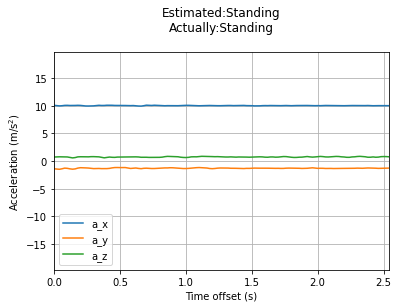

KeyboardInterrupt: 

In [66]:
%matplotlib inline
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
for k in range(atx.shape[0]):
    ax = atx[k, :]
    ay = aty[k, :]
    az = atz[k, :]

    f = featuresFromBuffer(ax, ay, az, fs)

    net = torch.load('C:/Users/bailing/Desktop/siganl processing/model/est_model.pth') # 提取模型
    f = Variable(torch.tensor(f,dtype=torch.float))
    net.eval()
    out = net(f)
    pred = out.argmax()
    estimatedActivity = actnames[0][pred][0]
    actualActivity = actnames[0][actid[k]][0]

    plotAccelerationBufferAndPrediction(
        ax, ay, az, t, actualActivity, estimatedActivity)

用神经网络分类每个样本，并画出三轴加速度的图像与实际类型、预测结果

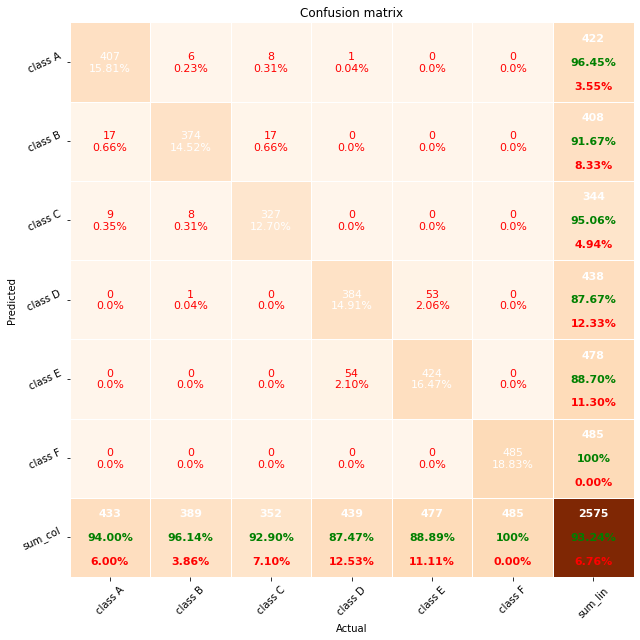

In [68]:
test_set = Testset()
test_dataloader = DataLoader(test_set, batch_size=1, shuffle=True)
net = torch.load('C:/Users/bailing/Desktop/siganl processing/model/est_model.pth')
preds = np.array([])
labels = np.array([])
for im, label in test_dataloader:
    im = Variable(im)
    label = Variable(label)
    net.eval()
    out = net(im)
    pred = out.argmax()
    preds = np.append(preds,pred.cpu().numpy())
    labels = np.append(labels,label.cpu().numpy())

pp_matrix_from_data(labels,preds)


画出混淆矩阵